In [1]:
import sys
import json

general = {'use_road_network': True}
footpaths = {'max_length': '1000', 'speed': '4.8', 'n_ntlegs': '2'}

params = {'footpaths': footpaths, 'general': general}


default = {'training_folder': '../../', 'scenario': 'montreal', 'params': params, 'period': ''}
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))
print(argv)


{'training_folder': '../../', 'scenario': 'montreal', 'params': {'footpaths': {'max_length': '1000', 'speed': '4.8', 'n_ntlegs': '2'}, 'general': {'use_road_network': True}}, 'period': ''}


In [2]:
import os
import geopandas as gpd
import pandas as pd

sys.path.insert(0, r'../../../quetzal')  # Add path to quetzal
from shapely.geometry import Point, LineString
from quetzal.model import stepmodel
from quetzal.io.quenedi import read_parameters, restrict_df_to_variant
from syspy.spatial.utils import get_epsg
from syspy.spatial.spatial import DBSCAN_sclustering, voronoi_diagram_dataframes, zone_clusters, get_links_hull


on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = os.cpu_count()
print('num cores:', num_cores, 'on_lambda:', on_lambda)

num cores: 8 on_lambda: False


# Folders stucture and params

everything is on S3 (nothing on ECR) so no direct input folder. just scenarios/{scen}/inputs/

In [3]:
period = argv.get('period', '')

In [4]:
scenario = argv['scenario']
training_folder = argv['training_folder']

# if local. add the path to the scenario scenarios/<scenario>/
local_scen_path = '' if on_lambda else os.path.join('scenarios/', scenario)

input_folder = os.path.join(training_folder, 'inputs/')
scenario_folder = os.path.join(training_folder, local_scen_path, 'inputs/')
model_folder = os.path.join(training_folder, local_scen_path, 'model/')
output_folder = os.path.join(training_folder, local_scen_path, 'outputs/', period)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

print('input folder: ', scenario_folder)
print('output folder: ', output_folder)

input folder:  ../../scenarios/montreal/inputs/
output folder:  ../../scenarios/montreal/outputs/


In [5]:
params = read_parameters(argv['params'], period=period)

In [6]:
max_length = float(params['footpaths']['max_length'])
speed = float(params['footpaths']['speed'])
n_ntlegs = int(params['footpaths']['n_ntlegs'])
cutoff = 3 * 60 * 60  # 3 hours
use_road_network = params['general'].get('use_road_network', False)

# inputs

In [7]:
links = gpd.read_file(os.path.join(scenario_folder, 'pt', 'links.geojson'))
nodes = gpd.read_file(os.path.join(scenario_folder, 'pt', 'nodes.geojson'))
links = links.set_index('index')
nodes = nodes.set_index('index')

In [8]:
rnodes_file = os.path.join(scenario_folder, 'road', 'road_nodes.geojson')
walk_on_road = os.path.isfile(rnodes_file) and use_road_network
if walk_on_road:
    rnodes = gpd.read_file(os.path.join(scenario_folder, 'road', 'road_nodes.geojson'))
    rnodes = rnodes.set_index('index')
    rlinks = gpd.read_file(os.path.join(scenario_folder, 'road', 'road_links.geojson'))
    rlinks = rlinks.set_index('index')
    rlinks['walk_time'] = rlinks['length'] / speed * 3.6
    rlinks

print('rnodes?', walk_on_road)

rnodes? True


# Preparation

In [9]:
def add_col(links, col='length'):
    if col not in links.columns:
        return True
    elif any(links[col].isnull()):
        return True
    else:
        return False

In [10]:
if add_col(links, 'length'):
    print('add length')
    centroid = [*LineString(nodes.centroid.values).centroid.coords][0]
    crs = get_epsg(centroid[1], centroid[0])
    print('create length from geometry')
    links['length'] = links.to_crs(crs).length

if add_col(links, 'speed'):
    print('add speed')
    links['speed'] = links['length'] / links['time'] * 3.6


In [11]:
ab_set = sorted(set(links['a']).union(set(links['b'])))
nodes = nodes.loc[ab_set]

In [12]:
links = restrict_df_to_variant(links, period)
# only keep links with headway not 0
links = links[links['headway'] != 0]

keep and rename:  {}
drops:  []


In [13]:
sm = stepmodel.StepModel(epsg=4326)
sm.links = links.copy()
sm.nodes = nodes.copy()
if walk_on_road:
    sm.road_links = rlinks
    sm.road_nodes = rnodes

In [14]:
# clustering and rename nodes
sm.preparation_clusterize_nodes(distance_threshold=1e-4, fast=True, prefix='cnode_')  # ~10m
sm.nodes.index.name = 'index'

can not add prefixes on table:  footpaths


# Isochrone

get envelope fo clip the voronoi

In [ ]:
clip_geometry = get_links_hull(sm.links, tolerance=1e-2)

1) Clusterize nodes that are really close

In [55]:
clustered_nodes = sm.nodes.copy()
label = DBSCAN_sclustering(clustered_nodes, distance_threshold=2e-3)
label = 'node_cluster_' + label.astype(str)
clustered_nodes['cluster'] = label
nodes_cluster_series = clustered_nodes['cluster']

clustered_nodes = clustered_nodes.drop_duplicates('cluster')
clustered_nodes = clustered_nodes.reset_index().set_index('cluster')

# sm.nodes['cluster'] = nodes_cluster_series


2) create a voronoi with nodes clusters

In [ ]:
voronoi, _ = voronoi_diagram_dataframes(clustered_nodes['geometry'])
voronoi.crs = 4326

voronoi = voronoi.clip()

3) Clusterize the voronoi into 500 zones


In [57]:
from shapely.ops import unary_union

clusters, cluster_series = zone_clusters(voronoi, n_clusters=500, geo_join_method=lambda x: unary_union(x))
clusters = gpd.GeoDataFrame(clusters)

cluster_series = 'zones_' + cluster_series.astype(str)
clusters.index = 'zones_' + clusters.index.astype(str)
clusters.index.name = 'index'


In [58]:
zone_cluster_dict = cluster_series.reset_index().groupby('cluster')['index'].agg(list).to_dict()
clusters['node_cluster_list'] = clusters.index.map(zone_cluster_dict.get)
clusters['node_cluster_id'] = clusters['node_cluster_list'].apply(lambda x: x[0])

In [59]:
node_cluster_dict = nodes_cluster_series.reset_index().groupby('cluster')['index'].agg(list).to_dict()
clusters['node_list'] = clusters['node_cluster_list'].apply(lambda x: [*map(node_cluster_dict.get, x)])
clusters['node_list'] = clusters['node_list'].apply(lambda ls: [item for sublist in ls for item in sublist])  # flatten
clusters['node_id'] = clusters['node_list'].apply(lambda x: x[0])

4) pathfinder

In [60]:
zones = sm.nodes.loc[clusters['node_id'].values].copy()
zones = zones.reset_index().rename(columns={'index': 'node_id'})
zone_node_dict = clusters.reset_index().set_index('node_id')['index'].to_dict()

zones.index = zones['node_id'].apply(zone_node_dict.get)
zones.index.name = 'index'

In [61]:
clusters[['geometry']].to_file(os.path.join(output_folder, 'isochrone.geojson'), driver='GeoJSON')

In [62]:
self = sm.copy()
self.zones = zones.copy()

In [63]:
# need to clusterize a bit. else footpaths wont work.
# self.preparation_clusterize_nodes(distance_threshold=1e-4)
self.preparation_footpaths(speed=speed, max_length=max_length)

self.footpaths = self.footpaths.drop(columns='voronoi')
self.footpaths['speed'] = self.footpaths['length'] / self.footpaths['time'] * 3.6

In [64]:
self.preparation_ntlegs(
    short_leg_speed=speed,
    long_leg_speed=speed,  # tout le monde marche
    zone_to_transit=True,
    zone_to_road=walk_on_road,
    road_to_transit=walk_on_road,
    n_ntlegs=n_ntlegs,
)

connect zone to every nodes in its cluster

In [65]:
zone_to_transit = clusters[['node_list']].explode('node_list').reset_index()

zone_to_transit['rank'] = 0
zone_to_transit['distance'] = 0
zone_to_transit['geometry'] = LineString([[0, 0], [0, 0]])
zone_to_transit['direction'] = 'access'
zone_to_transit['speed_factor'] = 0
zone_to_transit['short_leg_speed'] = speed
zone_to_transit['long_leg_speed'] = speed
zone_to_transit['speed'] = speed
zone_to_transit['time'] = 0
zone_to_transit['walk_time'] = 0


In [66]:
access = zone_to_transit.rename(columns={'index': 'a', 'node_list': 'b'})
eggress = zone_to_transit.rename(columns={'index': 'b', 'node_list': 'a'})
eggress['direction'] = 'eggress'

In [67]:
self.zone_to_transit = pd.concat([self.zone_to_transit, access, eggress], ignore_index=True)

In [68]:
self.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=False,
    keep_pathfinder=True,
    cutoff=cutoff,
    mode_column='route_type',
    route_column='route_id',
    speedup=True,
    walk_on_road=walk_on_road,
    path_analysis=False,
)

start publicpathfinder
500 sources 500 targets direct search
path_analysis


In [69]:
self.pt_los['time (mins)'] = self.pt_los['gtime'] / 60

In [70]:
def agg_func(x):
    return dict(x.values)


json_data = {}
grouped = self.pt_los.groupby(['origin', 'destination'])['time (mins)'].sum().reset_index()
grouped['time (mins)'] = list(zip(grouped['destination'], grouped['time (mins)']))
data = grouped.groupby('origin').agg({'time (mins)': agg_func}).to_dict()
json_data.update(data)

In [71]:
with open(os.path.join(output_folder, 'isochrone.json'), 'w') as json_file:
    json.dump(json_data, json_file)

# OD pathfinder

In [72]:
od_file = os.path.join(scenario_folder, 'od', 'od.geojson')
od_file_provided = os.path.isfile(od_file)
if od_file_provided:
    od_test = gpd.read_file(od_file)
    if 'name' not in od_test.columns:
        od_test['name'] = od_test['index']
    od_test['name'] = od_test['name'].fillna(od_test['index'].astype(str))
else:
    print('end of pathfinder')
    end_of_notebook

end_of_notebook here if OD_file not provided!!

In [73]:
od_test['geometry_o'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][0]))
od_test['geometry_d'] = od_test['geometry'].apply(lambda g: Point(g.coords[:][1]))

od_test['origin'] = od_test['index'].astype(str) + '_o'
od_test['destination'] = od_test['index'].astype(str) + '_d'


zones = od_test.copy()
zones_d = od_test.copy()
zones['geometry'] = zones['geometry_o']
zones_d['geometry'] = zones_d['geometry_d']
zones['index'] = zones['origin']
zones_d['index'] = zones_d['destination']
zones = pd.concat([zones[['index', 'geometry']], zones_d[['index', 'geometry']]])
zones = zones.set_index('index')

od_set = set(zip(od_test['origin'], od_test['destination']))


# Walkmodel

In [74]:
sm.zones = zones

# sm.road_links = rlinks
# sm.road_nodes = rnodes

In [75]:
sm.preparation_footpaths(speed=speed, max_length=max_length)

sm.footpaths = sm.footpaths.drop(columns='voronoi')
sm.footpaths['speed'] = sm.footpaths['length'] / sm.footpaths['time'] * 3.6

In [76]:
# Access footpaths (zone_to_road and road_to_transit)
sm.preparation_ntlegs(
    short_leg_speed=speed,
    long_leg_speed=speed,  # tout le monde marche
    threshold=1000,
    zone_to_transit=True,
    zone_to_road=walk_on_road,
    road_to_transit=walk_on_road,
    n_ntlegs=n_ntlegs,
    # max_ntleg_length=2000,
)

# pathfinder

In [77]:
sm.step_pt_pathfinder(
    broken_routes=False,
    broken_modes=False,
    keep_pathfinder=True,
    mode_column='route_type',
    route_column='route_id',
    speedup=True,
    walk_on_road=walk_on_road,
    path_analysis=False,
    od_set=od_set,
)


start publicpathfinder
14 sources 14 targets direct search
path_analysis


In [78]:
sm.analysis_pt_los(walk_on_road=walk_on_road)

path_analysis: 100%|██████████| 14/14 [00:00<00:00, 33007.45it/s]


# create path

In [86]:
od_links = od_test.merge(sm.pt_los[['origin', 'destination', 'gtime', 'link_path']], on=['origin', 'destination'])
od_links = od_links.drop(columns=['geometry', 'geometry_o', 'geometry_d', 'origin', 'destination'])
od_links = od_links.explode('link_path')
# may add route_width if quenedi can handle it one day.
od_links = od_links.merge(sm.links[['route_color', 'geometry', 'time', 'speed']], left_on='link_path', right_index=True)
# od_links = od_links.drop(columns='link_path')

In [87]:
od_ntlegs = od_test.merge(sm.pt_los[['origin', 'destination', 'gtime', 'ntlegs']], on=['origin', 'destination'])
od_ntlegs = od_ntlegs.drop(columns=['geometry', 'geometry_o', 'geometry_d', 'origin', 'destination'])
od_ntlegs = od_ntlegs.explode('ntlegs')

ntlegs_dict = sm.zone_to_transit.reset_index().set_index(['a', 'b'])['index'].to_dict()
od_ntlegs['ntlegs'] = od_ntlegs['ntlegs'].apply(ntlegs_dict.get)

od_ntlegs = od_ntlegs.merge(sm.zone_to_transit[['geometry', 'time', 'speed']], left_on='ntlegs', right_index=True)
od_ntlegs = od_ntlegs.drop(columns='ntlegs')
# od_ntlegs['route_color']='4B4B4B'

In [88]:
od_footpaths = od_test.merge(sm.pt_los[['origin', 'destination', 'gtime', 'footpaths']], on=['origin', 'destination'])
od_footpaths = od_footpaths.drop(columns=['geometry', 'geometry_o', 'geometry_d', 'origin', 'destination'])
od_footpaths = od_footpaths.explode('footpaths')

footpaths_dict = sm.footpaths.reset_index().set_index(['a', 'b'])['index'].to_dict()
od_footpaths['footpaths'] = od_footpaths['footpaths'].apply(footpaths_dict.get)

od_footpaths = od_footpaths.merge(sm.footpaths[['geometry', 'time', 'speed']], left_on='footpaths', right_index=True)
od_footpaths = od_footpaths.drop(columns='footpaths')

In [89]:
od_route = pd.concat([od_links, od_footpaths, od_ntlegs], axis=0)

In [ ]:
od_route['route_color'] = od_route['route_color'].fillna('838383').replace('null', '838383')
od_route['route_color'] = od_route['route_color'].apply(lambda c: f'#{c.strip()}')

In [101]:
od_route = od_route.rename(columns={'name': 'od_name'}).drop(columns='index')
od_route.reset_index(drop=True)
od_route.index.name = 'index'

In [102]:
od_route = gpd.GeoDataFrame(od_route, crs=4326)
od_route.to_file(os.path.join(output_folder, 'od_route.geojson'), driver='GeoJSON')

# export PT lost metrics

In [103]:
sm.analysis_pt_time(walk_on_road=walk_on_road)
sm.analysis_pt_route_type(['rail', 'subway', 'tram', 'bus', 'ferry', 'cable_car', 'gondola', 'funicular'])
pt_los = od_test[['origin', 'destination', 'name']].merge(sm.pt_los, on=['origin', 'destination'])

In [104]:
pt_los['walking_time'] = pt_los['access_time'] + pt_los['footpath_time']
time_per_mode_cols = []
# get in_vehicle_time per modes
mode_list = sm.links['route_type'].unique()
for mode in mode_list:
    time_dict = sm.links[sm.links['route_type'] == mode]['time'].to_dict()
    col = f'{mode}_time'
    pt_los[col] = pt_los['path'].apply(lambda ls: sum([time_dict.get(el, 0) for el in ls]))
    time_per_mode_cols.append(col)


In [105]:
time_cols = ['walking_time', 'waiting_time', 'boarding_time', *time_per_mode_cols]
cols = ['name', 'time', 'in_vehicle_time', *time_cols, 'ntransfers', 'route_types']
pt_los = pt_los[cols]
pt_los.index.name = 'index'

In [106]:
pt_los.to_csv(os.path.join(output_folder, 'od_los.csv'))

# Bar plot

In [107]:
import matplotlib.pyplot as plt

systra_colors = [
    '#74a9cf',
    '#0570b0',
    '#bdc9e1',
    '#b2df8a',
    '#33a02c',
    '#fb9a99',
    '#e31a1c',
    '#fdbf6f',
    '#ff7f00',
    '#cab2d6',
    '#6a3d9a',
]


In [108]:
to_plot = pt_los.copy()
to_plot = to_plot.set_index('name')
to_plot[time_cols] = to_plot[time_cols] / 60

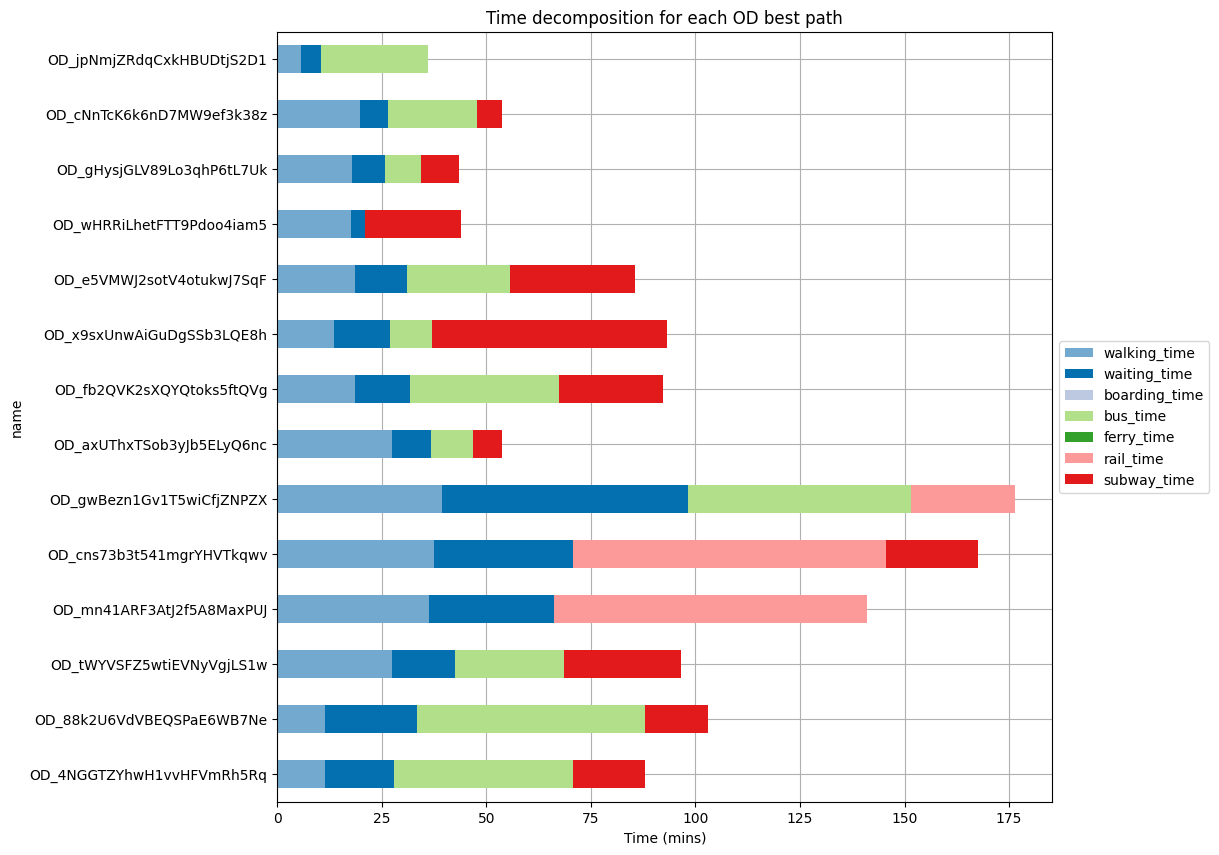

In [109]:
ax = to_plot[time_cols].plot(kind='barh', stacked=True, figsize=(10, 10), color=systra_colors)
plt.legend(loc='upper right', ncol=1)
plt.gca().invert_yaxis()
plt.xlabel('Time (mins)')
plt.grid(True, 'major', linestyle='-', axis='both')
ax.set_axisbelow(True)
plt.legend(time_cols, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.title('Time decomposition for each OD best path')
plt.savefig(os.path.join(output_folder, 'od_time_decomposition.png'))

# Png of paths

In [110]:
from syspy.spatial.spatial import plot_lineStrings


In [111]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO


def lonlat_to_meters(lon, lat):
    """Convert lon/lat to meters in Web Mercator."""
    origin_shift = 2 * np.pi * 6378137 / 2.0
    mx = lon * origin_shift / 180.0
    my = np.log(np.tan((90 + lat) * np.pi / 360.0)) * 6378137
    return mx, my


def calculate_zoom_to_fit_bbox(minx, miny, maxx, maxy, target_width_px, target_height_px, tile_size=256):
    """
    Calculate the appropriate zoom level to fit a bounding box into a fixed pixel size.
    Returns an approximate integer zoom.
    """
    # Convert bbox corners to Web Mercator meters
    mx1, my1 = lonlat_to_meters(minx, miny)
    mx2, my2 = lonlat_to_meters(maxx, maxy)

    # Get span in meters
    width_m = abs(mx2 - mx1)
    height_m = abs(my2 - my1)

    # Calculate resolution required (meters per pixel)
    res_x = width_m / target_width_px
    res_y = height_m / target_height_px
    target_res = max(res_x, res_y)

    # Initial resolution at zoom 0
    initial_res = 2 * np.pi * 6378137 / tile_size

    # Compute zoom level from resolution
    zoom = np.log2(initial_res / target_res)

    return int(round(zoom))


def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = np.radians(lat_deg)
    n = 2.0**zoom
    xtile = int((lon_deg + 180.0) / 360.0 * n)
    ytile = int((1.0 - np.log(np.tan(lat_rad) + 1 / np.cos(lat_rad)) / np.pi) / 2.0 * n)
    return (xtile, ytile)


def num2deg(xtile, ytile, zoom):
    n = 2.0**zoom
    lon_deg = xtile / n * 360.0 - 180.0
    lat_rad = np.atan(np.sinh(np.pi * (1 - 2 * ytile / n)))
    lat_deg = np.degrees(lat_rad)
    return (lat_deg, lon_deg)


def create_basemap(ax, image_size_px=(512, 512)):
    miny, maxy = ax.get_ylim()
    minx, maxx = ax.get_xlim()
    # Fixed image resolution
    zoom = calculate_zoom_to_fit_bbox(minx, miny, maxx, maxy, image_size_px[0], image_size_px[1])

    print(f'Zoom : {zoom}')

    x_min, y_max = deg2num(miny, minx, zoom)
    x_max, y_min = deg2num(maxy, maxx, zoom)

    width = x_max - x_min + 1
    height = y_max - y_min + 1

    # Create a blank image
    tile_size = 256
    basemap = Image.new('RGB', (width * tile_size, height * tile_size))
    # Download and stitch tiles
    for x in range(x_min, x_max + 1):
        for y in range(y_min, y_max + 1):
            url = f'http://a.basemaps.cartocdn.com/light_nolabels/{zoom}/{x}/{y}.png'
            response = requests.get(url)
            tile = Image.open(BytesIO(response.content))
            basemap.paste(tile, ((x - x_min) * tile_size, (y - y_min) * tile_size))

    # Show basemap image
    lat_top_left, lon_top_left = num2deg(x_min, y_min, zoom)
    lat_bottom_right, lon_bottom_right = num2deg(x_max + 1, y_max + 1, zoom)
    ax.imshow(basemap, extent=[lon_top_left, lon_bottom_right, lat_bottom_right, lat_top_left], aspect='equal')
    ax.set_xlim([minx, maxx])
    ax.set_ylim([miny, maxy])


Zoom : 13
Zoom : 13
Zoom : 13
Zoom : 12
Zoom : 11
Zoom : 11
Zoom : 12
Zoom : 13
Zoom : 11
Zoom : 10
Zoom : 10
Zoom : 11
Zoom : 11
Zoom : 11


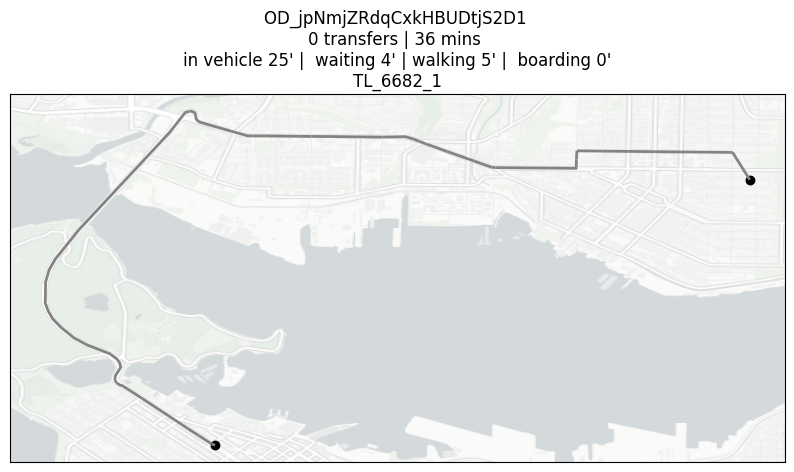

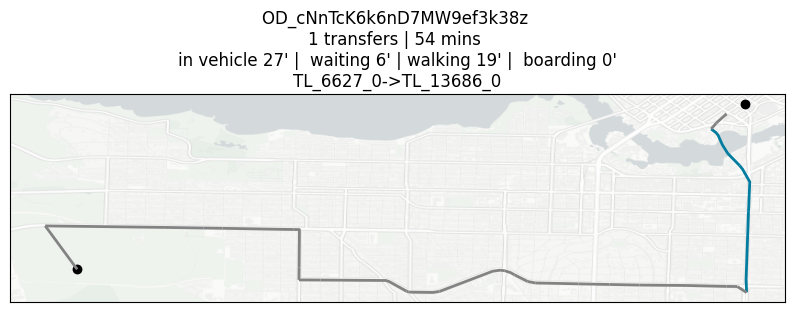

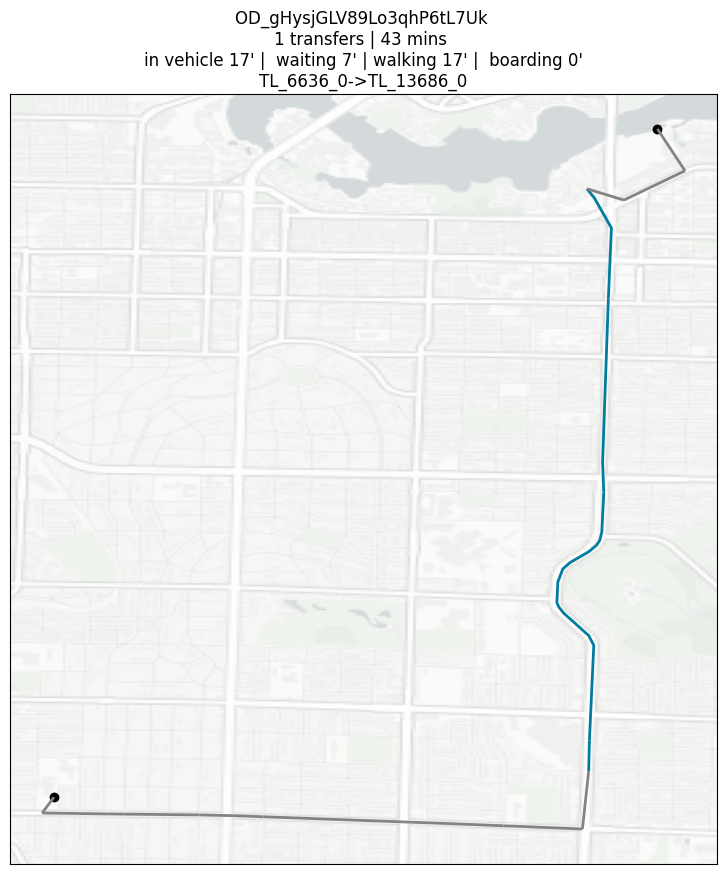

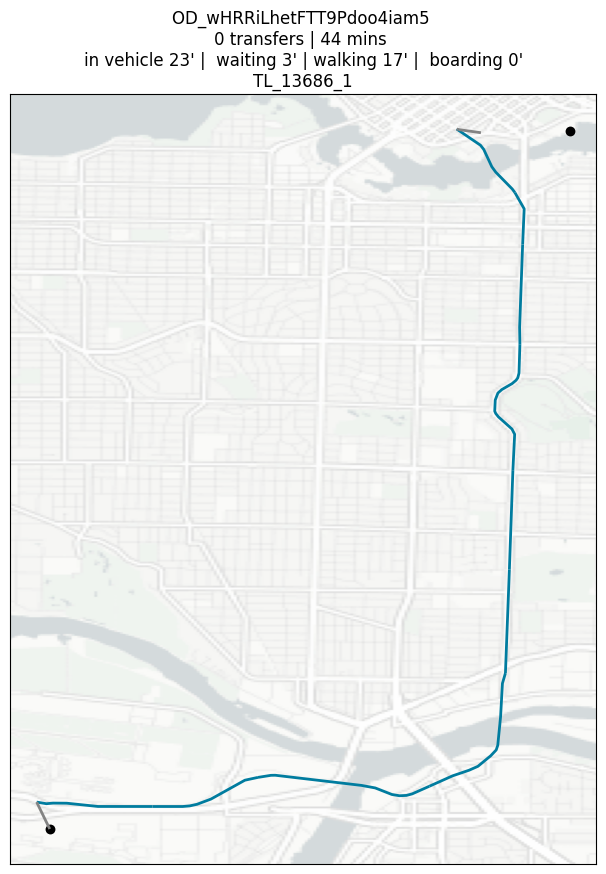

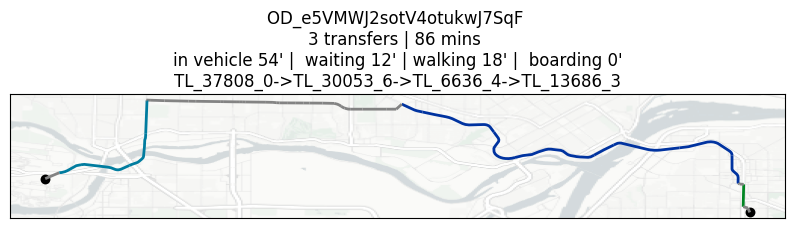

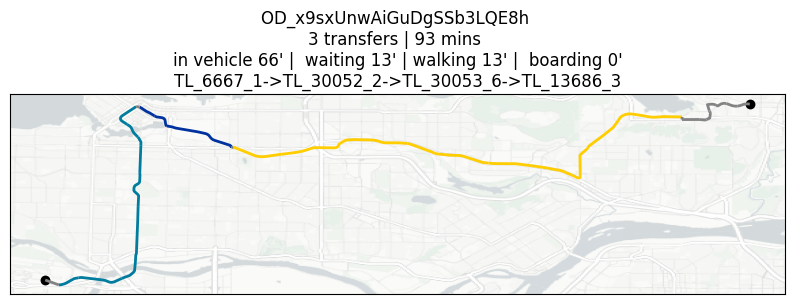

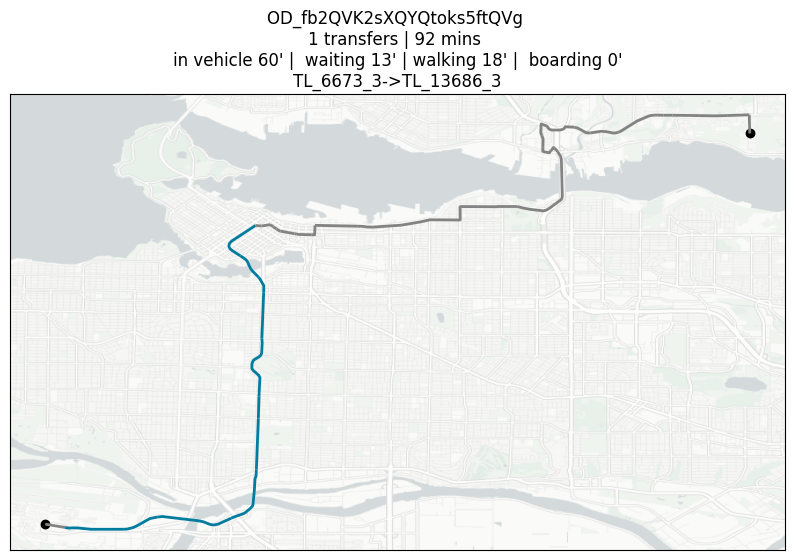

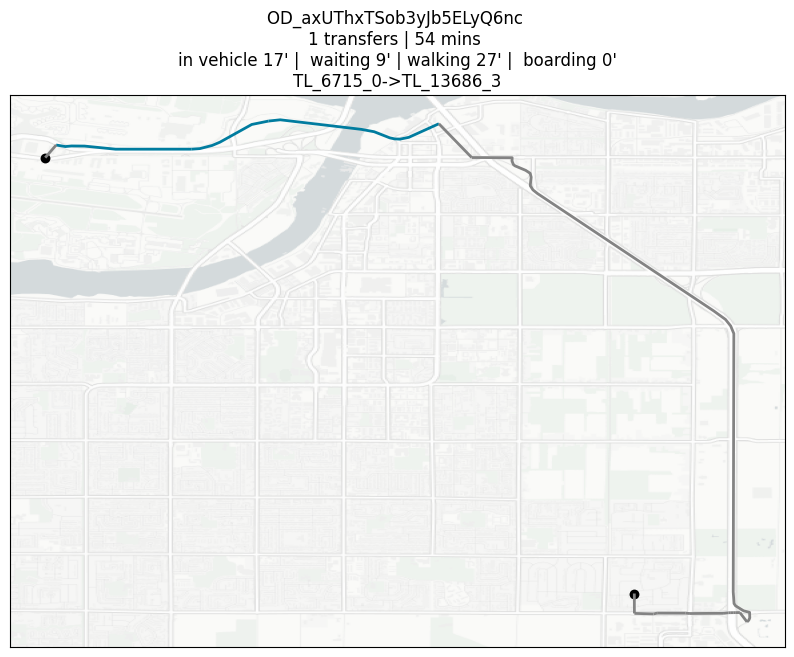

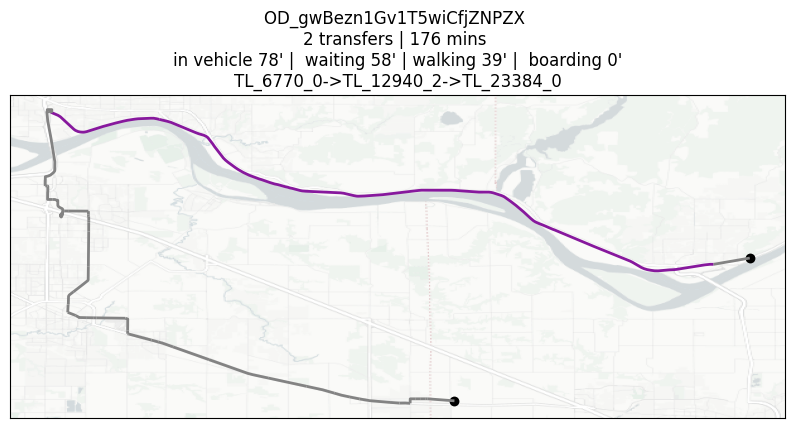

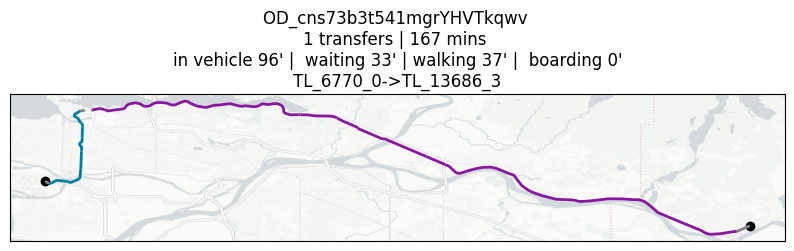

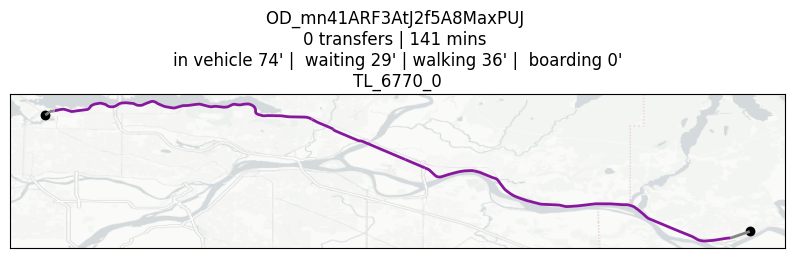

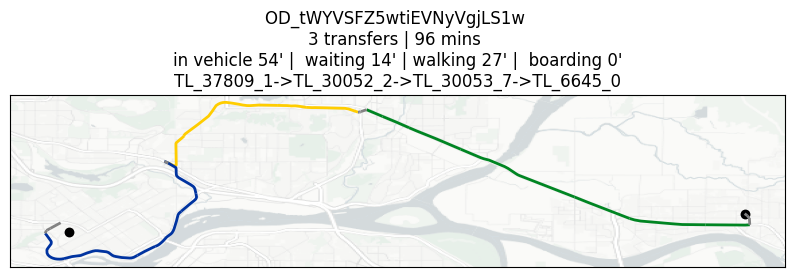

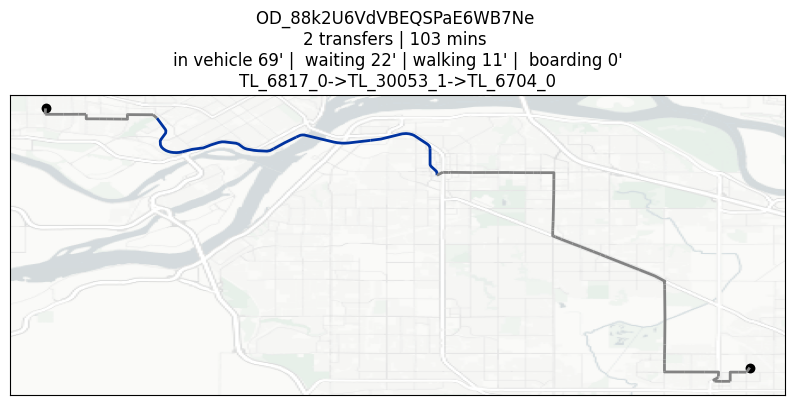

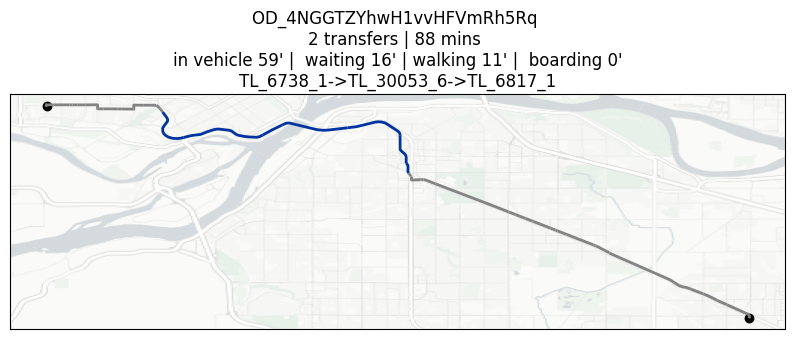

In [112]:
for origin, destination, name in od_test[['origin', 'destination', 'name']].values:
    fig, ax = plt.subplots(figsize=(10, 10))
    route = od_route[od_route['od_name'] == name]
    sm.od_basemap(origin=origin, destination=destination, squared=True, figsize=(10, 10), ax=ax)
    plot_lineStrings(route, ax=ax, linewidth=2, colors=route['route_color'])
    create_basemap(ax)

    ax.set_xticks([])
    ax.set_yticks([])

    title = f'{name} \n'

    path = pt_los[pt_los['name'] == name].iloc[0]
    path['min'] = np.round(path['time'] / 60).astype(int)
    mins = (
        (path[['in_vehicle_time', 'walking_time', 'waiting_time', 'boarding_time', 'time']] / 60)
        .astype(int)
        .astype(str)
    )
    title += f'{path['ntransfers']} transfers | {path['min']} mins '
    title += '\n' + 'in vehicle ' + mins['in_vehicle_time'] + "' | " + ' waiting ' + mins['waiting_time'] + "' | "
    title += 'walking ' + mins['walking_time'] + "' | " + ' boarding ' + mins['boarding_time'] + "'" + '\n'

    trip_dict = sm.links['trip_id'].to_dict()
    trip_list = route['link_path'].apply(trip_dict.get).drop_duplicates().dropna().to_list()
    title += '->'.join(trip_list)
    ax.set_title(title)

    png = f'OD_PT_{name}.png'
    fig.savefig(os.path.join(output_folder, png), bbox_inches='tight')


In [113]:
print('success')

success
